### Comparing two discprepant pathology calls by:
1. train on two different version of calls and find out cross validation AUC
2. train on consensus and apply signature to discrepant samples and find out how it agrees with either
3. only using small cell vs adeno

In [1]:
# %load startup_script.py

# numerical & stats 
import pandas as pd
import numpy as np
from scipy import stats

# plotting
from matplotlib import pyplot as plt
from bokeh.charts import Bar, output_file, show, BoxPlot, Line
from bokeh.io import output_notebook

# machine learning
from sklearn import linear_model

# misc
from pprint import pprint as pp

# my own module in the same repo
import helper

# jupyte notebook amenities
output_notebook()
%matplotlib inline
%autosave 10


Loading BokehJS ...

Autosaving every 10 seconds


In [3]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
consensus = "./data/NEPC/consensus_calls_050317.tsv"
discrepancy = "./data/NEPC/JH_v_LT_discrepant_calls_050317.tsv"
df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
df_consensus = pd.read_csv(consensus, delimiter="\t")
df_discrep = pd.read_csv(discrepancy, delimiter="\t")

In [11]:
def data_prep(df_call, df_mRNA, label_column=""):
    y = df_call.copy()
    y.rename(columns={"Consensus Path Call":"label",
                      label_column: "label",
                      "Patient ID": "Patient_ID",
                      "Path Call":"label"}, inplace=True)
    # remove samples with unwanted labels
    y = y[~y["label"].isin(
        ["QNS", "IAC/Small cell", "Indeterminate", "Cytology mixed", 
         "IAC/Adeno", "IAC", "Missing", "Adeno/Small cell", "IAC/adeno", 
         "? Small cell", "IAC/adeno"])].copy()
    # uniform various naming discrepancies
    y.set_index("Patient_ID", inplace=True)
    y[y["label"].isin(["Small cell", "Small Cell"])] = 1
    y[y["label"].isin(["Adenocarcinoma", "Adeno"])] = 0
    
    # get sample overlap between mRNA and y
    X = df_mRNA.set_index("gene_id").transpose()
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    y.label=pd.to_numeric(y.label)
    return X, y


def calc_signature(X, y, name, classifier=linear_model.LogisticRegression()):
    classifier.fit(X, np.array(list(y['label'])))
    return pd.DataFrame(index=X.columns, data=classifier.coef_[0], columns=[name])


def join_two_labels(df_consensus, df_call, call):
    df_consensus.rename(columns={"Consensus Path Call":"Path Call"}, inplace=True)
    df_call.rename(columns={call:"Path Call"}, inplace=True)
    return df_consensus.append(df_call, ignore_index=True)

In [12]:
# leave pair out cross validation with consensus calls
X, y = data_prep(df_consensus, df_mRNA)
print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

..............................................................................................................0.8272727272727273


In [13]:
# independent calls 
for call in ["JH/GT Path Call", "LT Independent Path Calls"]:
    df_combined = join_two_labels(df_consensus, 
                                  df_discrep[["Patient ID", call]].copy(), call)
    X, y = data_prep(df_combined, df_mRNA)
    print(call, "leave pair out cross validation AUC:")
    print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

JH/GT Path Call leave pair out cross validation AUC:
......................................................................................................................................................................................0.9175824175824175
LT Independent Path Calls leave pair out cross validation AUC:
................................................................................................................................................................................................................................0.71875


### train signature with Consensus and apply to JH/GT and LT calls

In [14]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def extract_X(df_mRNA, index_list=[]):
    X = df_mRNA.set_index("gene_id").transpose()
    X = X.loc[index_list]
    X.sort_index(inplace=True)
    return X

def get_consensus_sig():
    X, y = data_prep(df_consensus, df_mRNA)
    lr = linear_model.LogisticRegression()
    lr.fit(X.values,y.values.ravel())
    return lr.coef_[0]

def get_path_call_data(call, short_name):
    X, y = data_prep(df_discrep[["Patient ID", call]], df_mRNA, label_column=call)
    y.rename(columns={"label":short_name}, inplace=True)
    return X, y

def apply_signature(X, sig):
    linear_score = np.matmul(X.as_matrix(), signature)
    sigmoid_score = list(map(sigmoid, linear_score))
    return [linear_score, sigmoid_score]

In [15]:
X1, y1 = get_path_call_data("JH/GT Path Call", "JH/GT Path Calls")
X2, y2 = get_path_call_data("LT Independent Path Calls", "LT Path Calls")

y_combined = pd.concat([y1, y2], axis=1, join="outer")
X_combined = extract_X(df_mRNA, index_list=set(list(X1.index)+list(X2.index)))

signature = get_consensus_sig()
linear_score, sigmoid_score = apply_signature(X_combined, signature)
y_combined["linear_score"] = linear_score
y_combined["sigmoid_score"] = sigmoid_score

print(y_combined)

             JH/GT Path Calls  LT Path Calls  linear_score  sigmoid_score
DTB-022Pro                0.0            NaN     -8.564850       0.000191
DTB-024Pro2               NaN            0.0     -8.937655       0.000131
DTB-097                   0.0            NaN     -2.964422       0.049059
DTB-097Pro                NaN            0.0     -1.441318       0.191341
DTB-108                   NaN            1.0     -4.319793       0.013128
DTB-111Pro                NaN            0.0     -2.300043       0.091119
DTB-127Pro                NaN            0.0     -5.072552       0.006227
DTB-131                   NaN            1.0     -3.585753       0.026968
DTB-135                   NaN            1.0     -5.551938       0.003865
DTB-140                   0.0            NaN     -3.871451       0.020403
DTB-143                   NaN            0.0     -4.172603       0.015178
DTB-154                   0.0            NaN     -4.895383       0.007425
DTB-174                   1.0         

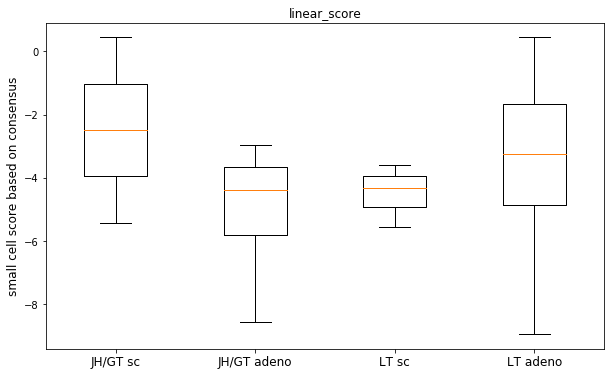

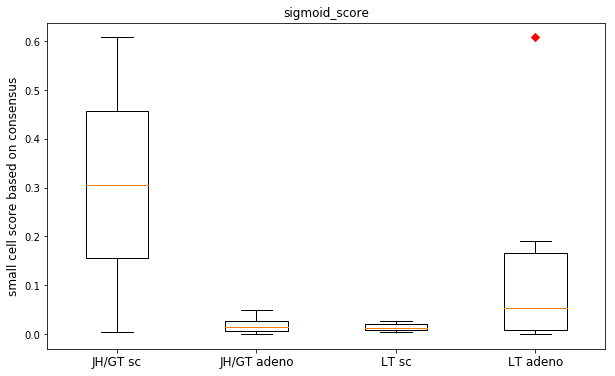

In [16]:
for score in ["linear_score","sigmoid_score"]:
    JH = y_combined[~y_combined.isnull()["JH/GT Path Calls"]]
    LT = y_combined[~y_combined.isnull()["LT Path Calls"]]
    JH_sc = list(JH[JH["JH/GT Path Calls"]==1][score])
    JH_adeno = list(JH[JH["JH/GT Path Calls"]==0][score])
    LT_sc = list(LT[LT["LT Path Calls"]==1][score])
    LT_adeno = list(LT[LT["LT Path Calls"]==0][score])
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.boxplot([JH_sc, JH_adeno, LT_sc, LT_adeno], 0, 'rD')
    plt.ylabel("small cell score based on consensus", fontsize=12)
    xtickNames = plt.setp(ax1, xticklabels=["JH/GT sc", "JH/GT adeno", "LT sc", "LT adeno"])
    plt.setp(xtickNames, rotation=0, fontsize=12)
    plt.title(score, fontsize=12)
    plt.show()